In [2]:
# 1.

import pandas as pd

df = pd.read_csv('data_news.csv')
df.head()

category                                           headline  \
0  WELLNESS              143 Miles in 35 Days: Lessons Learned   
1  WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2  WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  WELLNESS                     Oh, What a Difference She Made   
4  WELLNESS                                   Green Superfoods   

                                               links  \
0  https://www.huffingtonpost.com/entry/running-l...   
1  https://www.huffingtonpost.com/entry/talking-t...   
2  https://www.huffingtonpost.com/entry/crenezuma...   
3  https://www.huffingtonpost.com/entry/meaningfu...   
4  https://www.huffingtonpost.com/entry/green-sup...   

                                   short_description  \
0  Resting is part of training. I've confirmed wh...   
1  Think of talking to yourself as a tool to coac...   
2  The clock is ticking for the United States to ...   
3  If you want to be busy, keep trying to be perf...   
4  First, the bad news: Soda bread, corned beef a...   

                             keywords  
0                     running-lessons  
1           talking-to-yourself-crazy  
2  crenezumab-alzheimers-disease-drug  
3                     meaningful-life  
4                    green-superfoods

In [4]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing text or category
df.dropna(subset=['headline', 'short_description'], inplace=True)
df.reset_index(drop=True, inplace=True)

category                0
headline                0
links                   0
short_description       0
keywords             2668
dtype: int64


In [5]:
# Combine headline + short description for better context
df['text'] = df['headline'] + '. ' + df['short_description']
df['category'] = df['category'].str.upper()  # Standardize case for labels

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([
        lemmatizer.lemmatize(word)
        for word in text.split()
        if word not in stop_words
    ])
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['category', 'clean_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


category                                         clean_text
0  WELLNESS  mile day lesson learned resting part training ...
1  WELLNESS  talking crazy crazy helpful think talking tool...
2  WELLNESS  crenezumab trial gauge whether alzheimers drug...
3  WELLNESS  oh difference made want busy keep trying perfe...
4  WELLNESS  green superfoods first bad news soda bread cor...

In [6]:
# 2.

from sklearn.feature_extraction.text import CountVectorizer

# Initialize vectorizer
bow_vectorizer = CountVectorizer(max_features=5000)

# Fit and transform the text
X_bow = bow_vectorizer.fit_transform(df['clean_text'])

print(X_bow.shape)  # Rows = articles, Cols = top 5000 words

(50000, 5000)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the text
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

print(X_tfidf.shape)

(50000, 5000)


In [7]:
!pip install gensim

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
tokenized_text = [doc.split() for doc in df['clean_text']]

In [13]:
from gensim.models import Word2Vec
import numpy as np

# Train Word2Vec
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=2, workers=4)

# Create document vectors by averaging word vectors
def vectorize_doc(doc):
    words = [word for word in doc if word in w2v_model.wv]
    if not words:
        return np.zeros(100)
    return np.mean(w2v_model.wv[words], axis=0)

X_word2vec = np.array([vectorize_doc(doc) for doc in tokenized_text])
print(X_word2vec.shape)

(50000, 100)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each category
category_counts = df['category'].value_counts()
print(category_counts)

category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: count, dtype: int64


/tmp/ipython-input-15-252235638.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


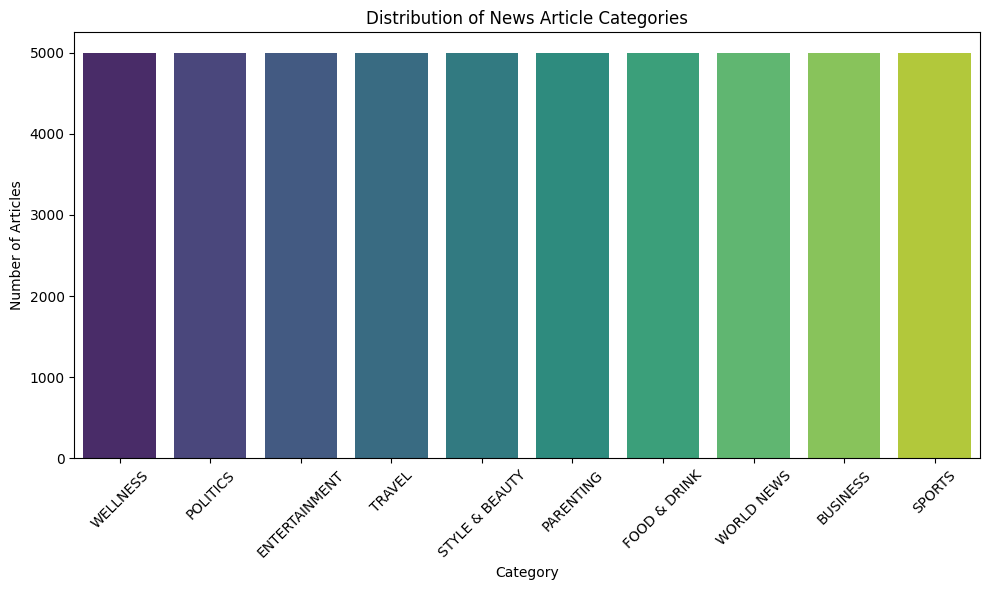

In [15]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of News Article Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

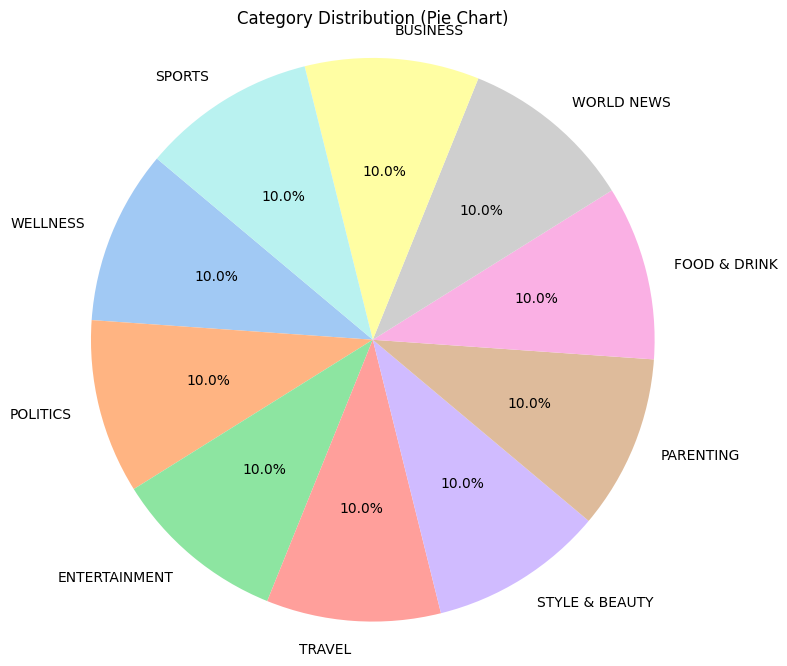

In [16]:
plt.figure(figsize=(8, 8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Category Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

In [17]:
# 3.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Create TF-IDF matrix from cleaned text
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

from sklearn.model_selection import train_test_split

X = X_tfidf
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Logistic Regression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))

Logistic Regression
                precision    recall  f1-score   support

      BUSINESS       0.73      0.78      0.76       955
 ENTERTAINMENT       0.77      0.78      0.77       985
  FOOD & DRINK       0.85      0.82      0.84      1021
     PARENTING       0.78      0.76      0.77      1030
      POLITICS       0.80      0.74      0.77      1034
        SPORTS       0.87      0.89      0.88       995
STYLE & BEAUTY       0.86      0.85      0.85       986
        TRAVEL       0.83      0.80      0.82      1008
      WELLNESS       0.72      0.75      0.74      1009
    WORLD NEWS       0.79      0.81      0.80       977

      accuracy                           0.80     10000
     macro avg       0.80      0.80      0.80     10000
  weighted avg       0.80      0.80      0.80     10000



In [22]:
# Naive Bayes

if 'X_tfidf' in globals():
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    y_pred_nb = nb.predict(X_test)

    print("Naive Bayes")
    print(classification_report(y_test, y_pred_nb))

Naive Bayes
                precision    recall  f1-score   support

      BUSINESS       0.71      0.73      0.72       955
 ENTERTAINMENT       0.80      0.74      0.77       985
  FOOD & DRINK       0.82      0.85      0.84      1021
     PARENTING       0.69      0.74      0.72      1030
      POLITICS       0.79      0.73      0.76      1034
        SPORTS       0.87      0.86      0.86       995
STYLE & BEAUTY       0.85      0.83      0.84       986
        TRAVEL       0.79      0.81      0.80      1008
      WELLNESS       0.71      0.72      0.72      1009
    WORLD NEWS       0.79      0.81      0.80       977

      accuracy                           0.78     10000
     macro avg       0.78      0.78      0.78     10000
  weighted avg       0.78      0.78      0.78     10000



In [23]:
# Support Vector Machine

svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("Support Vector Machine")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine
                precision    recall  f1-score   support

      BUSINESS       0.73      0.80      0.76       955
 ENTERTAINMENT       0.78      0.76      0.77       985
  FOOD & DRINK       0.83      0.84      0.83      1021
     PARENTING       0.77      0.75      0.76      1030
      POLITICS       0.78      0.73      0.76      1034
        SPORTS       0.87      0.91      0.89       995
STYLE & BEAUTY       0.83      0.85      0.84       986
        TRAVEL       0.82      0.78      0.80      1008
      WELLNESS       0.72      0.71      0.71      1009
    WORLD NEWS       0.77      0.79      0.78       977

      accuracy                           0.79     10000
     macro avg       0.79      0.79      0.79     10000
  weighted avg       0.79      0.79      0.79     10000



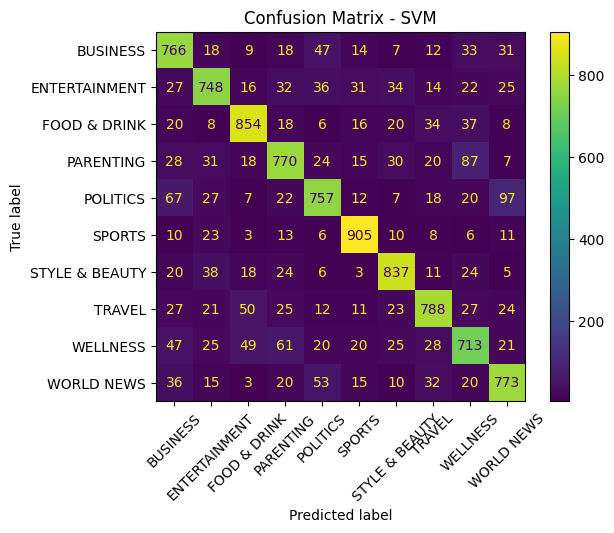

In [24]:
# Confusion Matrix Plot

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, xticks_rotation=45, cmap='viridis')
plt.title("Confusion Matrix - SVM")
plt.show()

In [25]:
# Training models on preprocessed data

# Importing libraries

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [26]:
# Logistic Regression

lr = LogisticRegression(max_iter=1000)
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(lr, lr_params, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_lr.fit(X_train, y_train)
y_pred_lr = grid_lr.predict(X_test)

print("Best Logistic Regression Params:", grid_lr.best_params_)
print(classification_report(y_test, y_pred_lr))

Best Logistic Regression Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
                precision    recall  f1-score   support

      BUSINESS       0.73      0.78      0.75       955
 ENTERTAINMENT       0.77      0.77      0.77       985
  FOOD & DRINK       0.85      0.84      0.84      1021
     PARENTING       0.77      0.77      0.77      1030
      POLITICS       0.80      0.73      0.77      1034
        SPORTS       0.86      0.88      0.87       995
STYLE & BEAUTY       0.86      0.85      0.85       986
        TRAVEL       0.83      0.80      0.82      1008
      WELLNESS       0.72      0.76      0.74      1009
    WORLD NEWS       0.79      0.82      0.80       977

      accuracy                           0.80     10000
     macro avg       0.80      0.80      0.80     10000
  weighted avg       0.80      0.80      0.80     10000



In [27]:
# Naive Bayes

nb = MultinomialNB()
nb_params = {
    'alpha': [0.01, 0.1, 1, 10]
}

grid_nb = GridSearchCV(nb, nb_params, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_nb.fit(X_train, y_train)
y_pred_nb = grid_nb.predict(X_test)

print("Best Naive Bayes Params:", grid_nb.best_params_)
print(classification_report(y_test, y_pred_nb))

Best Naive Bayes Params: {'alpha': 1}
                precision    recall  f1-score   support

      BUSINESS       0.71      0.73      0.72       955
 ENTERTAINMENT       0.80      0.74      0.77       985
  FOOD & DRINK       0.82      0.85      0.84      1021
     PARENTING       0.69      0.74      0.72      1030
      POLITICS       0.79      0.73      0.76      1034
        SPORTS       0.87      0.86      0.86       995
STYLE & BEAUTY       0.85      0.83      0.84       986
        TRAVEL       0.79      0.81      0.80      1008
      WELLNESS       0.71      0.72      0.72      1009
    WORLD NEWS       0.79      0.81      0.80       977

      accuracy                           0.78     10000
     macro avg       0.78      0.78      0.78     10000
  weighted avg       0.78      0.78      0.78     10000



In [28]:
# SVM

svm = LinearSVC()
svm_params = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge']
}

grid_svm = GridSearchCV(svm, svm_params, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_svm.fit(X_train, y_train)
y_pred_svm = grid_svm.predict(X_test)

print("Best SVM Params:", grid_svm.best_params_)
print(classification_report(y_test, y_pred_svm))

Best SVM Params: {'C': 0.1, 'loss': 'squared_hinge'}
                precision    recall  f1-score   support

      BUSINESS       0.74      0.77      0.75       955
 ENTERTAINMENT       0.80      0.77      0.78       985
  FOOD & DRINK       0.85      0.84      0.84      1021
     PARENTING       0.77      0.78      0.78      1030
      POLITICS       0.81      0.73      0.77      1034
        SPORTS       0.86      0.90      0.87       995
STYLE & BEAUTY       0.84      0.86      0.85       986
        TRAVEL       0.83      0.80      0.82      1008
      WELLNESS       0.73      0.75      0.74      1009
    WORLD NEWS       0.79      0.82      0.80       977

      accuracy                           0.80     10000
     macro avg       0.80      0.80      0.80     10000
  weighted avg       0.80      0.80      0.80     10000



In [31]:
# Cross validation

# Logistic Regression

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=grid_lr.best_params_['C'], penalty='l2', solver='liblinear', max_iter=1000)
cv_scores_lr = cross_val_score(lr, X, y, cv=5, scoring='f1_weighted')

print("Logistic Regression - F1 (5-fold):", cv_scores_lr)
print("Average F1:", cv_scores_lr.mean())

Logistic Regression - F1 (5-fold): [0.78322253 0.78730829 0.77705234 0.78506752 0.78280527]
Average F1: 0.7830911897879808


In [32]:
# Naive Bayes

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=grid_nb.best_params_['alpha'])
cv_scores_nb = cross_val_score(nb, X, y, cv=5, scoring='f1_weighted')

print("Naive Bayes - F1 (5-fold):", cv_scores_nb)
print("Average F1:", cv_scores_nb.mean())

Naive Bayes - F1 (5-fold): [0.77144721 0.77310389 0.76812761 0.77570565 0.77405057]
Average F1: 0.7724869874080588


In [33]:
# SVM

from sklearn.svm import LinearSVC

svm = LinearSVC(C=grid_svm.best_params_['C'], loss=grid_svm.best_params_['loss'])
cv_scores_svm = cross_val_score(svm, X, y, cv=5, scoring='f1_weighted')

print("SVM - F1 (5-fold):", cv_scores_svm)
print("Average F1:", cv_scores_svm.mean())

SVM - F1 (5-fold): [0.78672093 0.78697593 0.77993148 0.78893955 0.78544513]
Average F1: 0.7856026044830715


In [34]:
import pandas as pd

cv_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'SVM'],
    'Average F1-Score': [
        cv_scores_lr.mean(),
        cv_scores_nb.mean(),
        cv_scores_svm.mean()
    ]
})

print(cv_results)

                 Model  Average F1-Score
0  Logistic Regression          0.783091
1          Naive Bayes          0.772487
2                  SVM          0.785603


In [35]:
# 4.

# Evaluation

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
# Logistic Regression

y_pred_lr = grid_lr.predict(X_test)

print("Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression Report:

                precision    recall  f1-score   support

      BUSINESS       0.73      0.78      0.75       955
 ENTERTAINMENT       0.77      0.77      0.77       985
  FOOD & DRINK       0.85      0.84      0.84      1021
     PARENTING       0.77      0.77      0.77      1030
      POLITICS       0.80      0.73      0.77      1034
        SPORTS       0.86      0.88      0.87       995
STYLE & BEAUTY       0.86      0.85      0.85       986
        TRAVEL       0.83      0.80      0.82      1008
      WELLNESS       0.72      0.76      0.74      1009
    WORLD NEWS       0.79      0.82      0.80       977

      accuracy                           0.80     10000
     macro avg       0.80      0.80      0.80     10000
  weighted avg       0.80      0.80      0.80     10000

Accuracy: 0.7982


In [37]:
# Naive Bayes

y_pred_nb = grid_nb.predict(X_test)

print("Naive Bayes Report:\n")
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Report:

                precision    recall  f1-score   support

      BUSINESS       0.71      0.73      0.72       955
 ENTERTAINMENT       0.80      0.74      0.77       985
  FOOD & DRINK       0.82      0.85      0.84      1021
     PARENTING       0.69      0.74      0.72      1030
      POLITICS       0.79      0.73      0.76      1034
        SPORTS       0.87      0.86      0.86       995
STYLE & BEAUTY       0.85      0.83      0.84       986
        TRAVEL       0.79      0.81      0.80      1008
      WELLNESS       0.71      0.72      0.72      1009
    WORLD NEWS       0.79      0.81      0.80       977

      accuracy                           0.78     10000
     macro avg       0.78      0.78      0.78     10000
  weighted avg       0.78      0.78      0.78     10000

Accuracy: 0.7811


In [38]:
# SVM

y_pred_svm = grid_svm.predict(X_test)

print("SVM Report:\n")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Report:

                precision    recall  f1-score   support

      BUSINESS       0.74      0.77      0.75       955
 ENTERTAINMENT       0.80      0.77      0.78       985
  FOOD & DRINK       0.85      0.84      0.84      1021
     PARENTING       0.77      0.78      0.78      1030
      POLITICS       0.81      0.73      0.77      1034
        SPORTS       0.86      0.90      0.87       995
STYLE & BEAUTY       0.84      0.86      0.85       986
        TRAVEL       0.83      0.80      0.82      1008
      WELLNESS       0.73      0.75      0.74      1009
    WORLD NEWS       0.79      0.82      0.80       977

      accuracy                           0.80     10000
     macro avg       0.80      0.80      0.80     10000
  weighted avg       0.80      0.80      0.80     10000

Accuracy: 0.8013


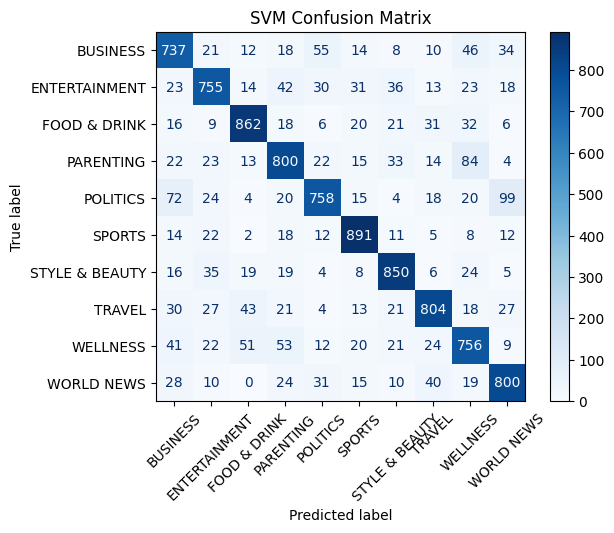

In [39]:
# Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix for best model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, xticks_rotation=45, cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()

In [40]:
from sklearn.metrics import f1_score

# Predictions from tuned models
y_pred_lr = grid_lr.predict(X_test)
y_pred_nb = grid_nb.predict(X_test)
y_pred_svm = grid_svm.predict(X_test)

# Collect performance metrics
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'SVM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_svm)
    ],
    'F1 Score (Weighted)': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_nb, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted')
    ]
})

print(model_comparison.sort_values(by='F1 Score (Weighted)', ascending=False))

                 Model  Accuracy  F1 Score (Weighted)
2                  SVM    0.8013             0.801062
0  Logistic Regression    0.7982             0.798367
1          Naive Bayes    0.7811             0.781263


In [ ]:
# Best Model is SVM as it has the highest accuracy (80.13%) and highest F1 Score (0.801).

In [ ]:
# Final Report

'''
Objective: Building a machine learning model that can automatically categorize
news stories into predetermined groups, such sports, politics, and technology.
Text preprocessing, feature extraction, training several models, assessing each
one's performance, and choosing the best model are all steps in the solution.

Feature Extraction:
Used BOW and TF-IDF Vectorization to convert text data into numerical features.
This helped us represent the importance of words while reducing the impact of common terms.

Exploratory Data Analysis (EDA):
Categories were visualized using a bar plot to detect distribution and class imbalance.
Some categories (e.g., wellness, politics) were more frequent than others.

Trained 3 classification algorithms:
Logistic Regression
Naive Bayes
Support Vector Machine (SVM)

Hyperparameter Tuning

Used GridSearchCV to tune:
C (regularization strength) for Logistic Regression & SVM
alpha (smoothing) for Naive Bayes

Cross-Validation:
5-fold cross-validation was applied to each model to ensure robust performance
and minimize overfitting.

Evaluation Metrics:
Each model was evaluated on:
Accuracy
Weighted F1-Score
Precision & Recall
Confusion Matrix

Best Model: SVM — highest accuracy and F1-score.

Conclusion:
Preprocessed and cleaned news data for ML modeling
Used TF-IDF to vectorize text
Trained 3 models, tuned them, validated using cross-validation
SVM selected as the final model based on superior F1 and accuracy
Model can now be deployed to classify unseen news articles
'''